# 4c. Improving the training loop

Now that we are able to compute the loss for our training data, we are able to train the model with the same couple of steps that we have encountered at the end of [**Notebook 2**](../2_Tensors/2b_Tensors_features_Solution.ipynb).

We will take this as a starting point to introduce the `torch.optim` package which provides us with the `Optimizer` API that greatly simplifies the training loop.

## Key concepts of this section

1. `Optimizer` API from the `torch.optim` package

In [3]:
import random
import math
import collections
import math
from typing import Tuple, List

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from workshop import data
import helper

## Training loop so far

Going back to the last section of [**Notebook 4b**](4b_loss_functions_Solutions.ipynb), we finished by calculating the per batch loss.

In [4]:
# Nothing new here, just repeating definitions for clarity ... don't do this at home!

class MnistDataSet:
    def __init__(self, train=True):
        subset = "training" if train else "test"
        self.x, self.y = torch.load(data.DATA_PATH / f"MNIST/processed/{subset}.pt")
        self.x = self.x.float()
    
    def __getitem__(self, key) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.x[key], self.y[key]
    
    def __len__(self):
        return len(self.x)
    
class MnistDataLoader:
    def __init__(self, dataset, batch_size, shuffle, transform=None):
        self.dataset, self.batch_size, self.shuffle, self.transform = dataset, batch_size, shuffle, transform
    
    def __iter__(self):
        self.idx = list(range(len(self.dataset)))
        if self.shuffle:
            random.shuffle(self.idx)
        return self
    
    def __next__(self):
        if self.idx:
            batch, self.idx = self.idx[:self.batch_size], self.idx[self.batch_size:]
            x, y = self.dataset[batch]
            if self.transform:
                return self.transform(x, y)
            return x, y
        
        raise StopIteration()

class ImageNormalizer:
    def __init__(self, mean, std):
        self.mean, self.std = mean, std
    
    def __call__(self, x, y):
        return (x - self.mean).div_(self.std), y

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.reshape(x.shape[0], -1)
        

def get_model():
    return torch.nn.Sequential(collections.OrderedDict([
        ("reshape", Flatten()),
        ("hidden", torch.nn.Linear(28*28,256)),
        ("sigmoid", torch.nn.Sigmoid()),
        ("output", torch.nn.Linear(256,10)),
      ]))

In [5]:
train_dl = MnistDataLoader(MnistDataSet(train=True), 1024, True, ImageNormalizer(33.32, 78.57))
test_dl = MnistDataLoader(MnistDataSet(train=False), 1024, True, ImageNormalizer(33.32, 78.57))
ce = torch.nn.CrossEntropyLoss()

def accuracy(preds, target):
    return (preds.max(-1)[1] == target).float().mean()

# for x, y in train_dl:
#     preds = model(x)
#     print(ce(preds, y))
#     print(accuracy(preds, y))
        

In [**Notebook 2**](../2_Tensors/2b_Tensors_features_Solution.ipynb) we already saw such a loop when finding the parameters for a **linear fit** to some data by minimizing the **MSE**.

Let's us try to reproduce this algorithm with our current setup!

In [6]:
def train_nn(model, n_epochs, lr):
    train_losses = np.array([])
    test_losses = np.array([])
    accuracies = np.array([])

    for epoch in range(n_epochs):
        for x, y in train_dl:
            train_loss = ce(model(x), y)
            train_loss.backward()
            train_losses = np.append(train_losses, train_loss.item())

            with torch.no_grad():
                for p in model.parameters():
                    p += - lr * p.grad
                    p.grad.data.zero_()

        test_loss, acc = evaluate_nn(model, test_dl)
        test_losses = np.append(test_losses, test_loss)
        accuracies = np.append(accuracies, acc)

        print(f"Epoch: {epoch} \t Training loss: {train_losses[-1]} \t Test loss: {test_losses[-1]} \t Test accurarcy: {accuracies[-1]}")
    return train_losses, test_losses, accuracies

def evaluate_nn(model, test_dl):
    preds = torch.tensor([])
    targets = torch.tensor([]).long()
    
    with torch.no_grad():
        for x, y in test_dl:
            targets = torch.cat([targets, y])
            preds = torch.cat([preds, model(x)])
        test_loss = ce(preds, targets)
    return test_loss.item(), accuracy(preds, targets).item()

def plot_metrics(train_losses, test_losses, accuracies):
    fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, figsize=(15,5))
    
    x = np.array(range(len(train_losses)))
    iterations_per_epoch = int(len(train_losses)/ len(test_losses))
    x_val = x[iterations_per_epoch - 1 :: iterations_per_epoch]
    ax0.plot(x, train_losses, label='train')
    ax0.plot(x_val, test_losses, label='test')
   
    ax0.legend()
    ax0.set_ylabel("Loss")
    ax0.set_xlabel("Iteration")
    
    ax1.set_ylabel("Accuracy")
    ax1.plot(x_val, accuracies)
    ax1.set_xlabel("Iteration")
    plt.tight_layout()

Epoch: 0 	 Training loss: 2.1422226428985596 	 Test loss: 2.141885280609131 	 Test accurarcy: 0.5304999947547913
Epoch: 1 	 Training loss: 2.014378547668457 	 Test loss: 1.986720085144043 	 Test accurarcy: 0.6547999978065491
Epoch: 2 	 Training loss: 1.8392235040664673 	 Test loss: 1.828647494316101 	 Test accurarcy: 0.6848000288009644
Epoch: 3 	 Training loss: 1.7008767127990723 	 Test loss: 1.6699120998382568 	 Test accurarcy: 0.727400004863739
Epoch: 4 	 Training loss: 1.5135055780410767 	 Test loss: 1.5186787843704224 	 Test accurarcy: 0.7409999966621399
Epoch: 5 	 Training loss: 1.4095394611358643 	 Test loss: 1.3811475038528442 	 Test accurarcy: 0.7620000243186951
Epoch: 6 	 Training loss: 1.2876858711242676 	 Test loss: 1.2599892616271973 	 Test accurarcy: 0.7803999781608582
Epoch: 7 	 Training loss: 1.171587347984314 	 Test loss: 1.1559786796569824 	 Test accurarcy: 0.7937999963760376
Epoch: 8 	 Training loss: 1.098181962966919 	 Test loss: 1.0673809051513672 	 Test accurarcy: 

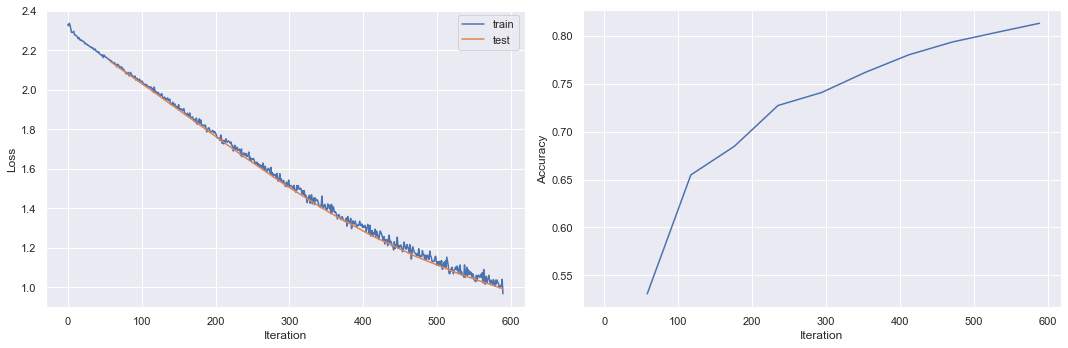

In [7]:
model = get_model()
train_losses, test_losses, accuracies = train_nn(model, n_epochs=10, lr=0.01)
plot_metrics(train_losses, test_losses, accuracies)

## PyTorch Optimizers

The above is a very neat example. The actual training code is only the part from l.6 to l.15, while the rest is mainly for logging.

However, it looks like the part from l.12 to l.15 is very generic and it can certainly be refactored away:

In [8]:
class Optimizer:
    def __init__(self, parameters, lr):
        self.parameters, self.lr = list(parameters), lr
    
    def step(self):
        with torch.no_grad():
            for p in self.parameters:
                p += - self.lr * p.grad
    
    def zero_grad(self):
        with torch.no_grad():
            for p in self.parameters:
                if p.grad is not None:
                    p.grad.data.zero_()
                
                
def train_nn(model, optim, n_epochs):
    train_losses = np.array([])
    test_losses = np.array([])
    accuracies = np.array([])

    for epoch in range(n_epochs):
        for x, y in train_dl:
            
            train_loss = ce(model(x), y)
            train_loss.backward()
            train_losses = np.append(train_losses, train_loss.item())

            optim.step()
            optim.zero_grad()

        test_loss, acc = evaluate_nn(model, test_dl)
        test_losses = np.append(test_losses, test_loss)
        accuracies = np.append(accuracies, acc)
        
        print(f"Epoch: {epoch} \t Training loss: {train_losses[-1]} \t Test loss: {test_losses[-1]} \t Test accurarcy: {accuracies[-1]}")
    return train_losses, test_losses, accuracies

Epoch: 0 	 Training loss: 2.1628494262695312 	 Test loss: 2.1434178352355957 	 Test accurarcy: 0.5440000295639038
Epoch: 1 	 Training loss: 1.9981096982955933 	 Test loss: 1.99239182472229 	 Test accurarcy: 0.6690000295639038
Epoch: 2 	 Training loss: 1.8405611515045166 	 Test loss: 1.8358711004257202 	 Test accurarcy: 0.7092000246047974
Epoch: 3 	 Training loss: 1.689213752746582 	 Test loss: 1.6777117252349854 	 Test accurarcy: 0.7430999875068665
Epoch: 4 	 Training loss: 1.5508522987365723 	 Test loss: 1.5246927738189697 	 Test accurarcy: 0.7598000168800354
Epoch: 5 	 Training loss: 1.4317032098770142 	 Test loss: 1.3841663599014282 	 Test accurarcy: 0.7807000279426575
Epoch: 6 	 Training loss: 1.2919681072235107 	 Test loss: 1.2594842910766602 	 Test accurarcy: 0.794700026512146
Epoch: 7 	 Training loss: 1.1704490184783936 	 Test loss: 1.1519755125045776 	 Test accurarcy: 0.8040000200271606
Epoch: 8 	 Training loss: 1.0895298719406128 	 Test loss: 1.0606199502944946 	 Test accurarc

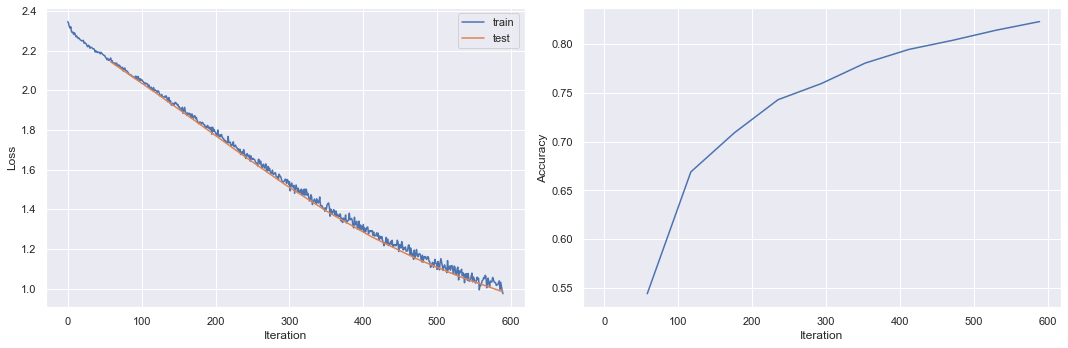

In [9]:
model = get_model()
train_losses, test_losses, accuracies = train_nn(model, Optimizer(model.parameters(), lr=0.01), n_epochs=10)
plot_metrics(train_losses, test_losses, accuracies)

torch.save(model.state_dict(), "../data/model.pt")

This basically introduces the core of what the [torch.optim.Optimizer](https://pytorch.org/docs/stable/_modules/torch/optim/optimizer.html#Optimizer) does. 

The `torch.optim` package, however, does not only offer an almost empty capsule for updating model parameters - it has all the deep learning batteries included: in our simple case, the weight update is performed with the **SGD** rule: 
$$\omega_t = \omega_{t-1} - \lambda * \nabla \omega$$

Much more advanced algorithms exist to perform the weight update, like **SGD with momentum**, **Adagrad**, **Adam**, ...

## Exercise 1:

Check the documentation for a couple of other optimizers and see if you can improve the model performance! 

In [10]:
# TODO: Exercise 1

## Exercise 2:

What other API is exposed by the `torch.optim` package?

In [11]:
# TODO: Exercise 2

## Section summary

The `torch.optim` package provides useful APIs and state-of-the-art algorithms for performing weight updates and learning rate scheduling.